In [3]:
from maze import *
import os
from scipy.stats import dirichlet
%matplotlib inline
from multiprocessing import Pool

### Define all trivial functionality here

In [6]:
def policy_evaluation(Q_init, M, world, r_state, gamma):
    
    num_states, num_actions = Q_init.shape
    
    probas = policy(Q_init, 1.5)
    Q_MB   = Q_init.copy()
    p_mean = M/np.sum(M, axis=1)[:, None]
    
    delta  = np.zeros_like(Q_init)
    
    while True:
        Q_old = Q_MB.copy()
        for s in np.delete(range(num_states), r_state):
            for a in range(num_actions):
                q_new = 0
                s1, _ = get_new_state(s, a, world, states, config_no_wall)
                if s1 == s:
                    q_new = np.nan
                else:

                    v     = np.nansum(probas * Q_MB, axis=1)
                    p_vec = p_mean[s*num_actions+a, :]
                    r     = world.ravel()
                    q_new = np.nansum(p_vec*(r + gamma*v))

                Q_MB[s, a] = q_new
                
        delta = Q_MB - Q_old
        if np.nanmax(abs(delta)) <= 1e-3:
            return Q_MB

def value_iteration(Q_init, M, world, r_state, gamma):
    
    num_states, num_actions = Q_init.shape
    
    Q_MB   = Q_init.copy()
    p_mean = M/np.sum(M, axis=1)[:, None]
    
    delta  = np.zeros_like(Q_init)
    
    while True:
        Q_old = Q_MB.copy()
        for s in np.delete(range(num_states), r_state):
            for a in range(num_actions):
                q_new = 0
                s1, _ = get_new_state(s, a, world, states, config_no_wall)
                if s1 == s:
                    q_new = np.nan
                else:

                    v     = np.nanmax(Q_MB, axis=1)
                    p_vec = p_mean[s*num_actions+a, :]
                    r     = world.ravel()
                    q_new = np.nansum(p_vec*(r + gamma*v))

                Q_MB[s, a] = q_new
                
        delta = Q_MB - Q_old
        if np.nanmax(abs(delta)) <= 1e-3:
            return Q_MB
        
def policy(q, beta):
    if len(q.shape[0]) == 1:
        return np.exp(q + beta)/np.nansum(np.exp(q + beta))
    else:
        return np.exp(q + beta)/np.nansum(np.exp(q + beta), axis=1)[:, None]

def gain(q_mf, q_mb, a, alpha, beta):
    
    if np.isnan(q_mf[a]):
        return np.nan
    
    q_mf_old  = q_mf.copy()
    probs_pre = policy(q_mf_old, beta)
    
    q_mf_new    = q_mf.copy()
    q_mf_new[a] = q_mf[a] + alpha*(q_mb[a] - q_mf[a])
    
    probs_after = policy(q_mf_new, beta)
    
    return np.nansum(q_mf_new*probs_after) - np.nansum(q_mf_old*probs_pre)

### Transition model prior pseudocounts

In [ ]:
M = np.ones((num_states*num_actions, num_states))

for s in np.delete(range(num_states), [r_state]):
    for a in range(num_actions):
        s1, _ = get_new_state(s, a, world, states, config_wall)
        M[s*num_actions+a, s1] += 1000
        
for a in range(num_actions):
    M[r_state*num_actions+a, start_state] += 1000

### Initialise MF Q values

In [ ]:
Q_init = np.zeros((num_states, num_actions))
gamma  = 0.9
Q_MF   = value_iteration(Q_init, M, world, r_state, gamma)

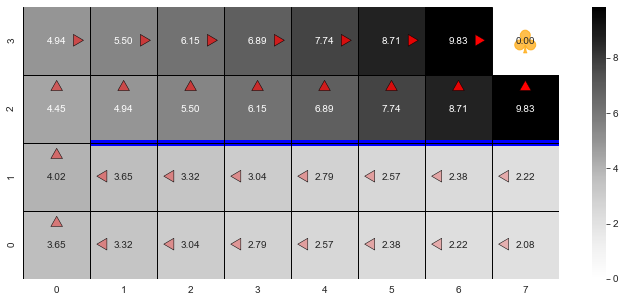

In [8]:
fig = plt.figure(figsize=(12, 5))
ax  = plt.subplot(111)
plot_maze_values(Q_MF, ax, hwall=[2, 1, 8], vwall=None)
# plt.savefig(os.path.join(os.getcwd(), 'mf_values.png'))

### Belief MDP value iteration

In [47]:
def get_belief_tree(s, a, h, b):

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(s, a, 0)] = b

    for hi in range(1, h):
        c  = 0
        for k, v in tree[hi-1].items():
            
            s = k[0]
            a = k[1]
            prev_c = k[-1]
            
            # Do not continue if reached reward state 
            if s == r_state:
                continue
            
            for s1 in range(num_states):
                
                b1 = v.copy()
                b1[s*num_actions+a, s1] += 10
                
                for a1 in range(num_actions):
                    
                    tree[hi][(s1, a1, prev_c, c)] = b1
                    c += 1
    return tree

def belief_vi(current_s, current_a, h, current_b):
    
    belief_tree    = get_belief_tree(current_s, current_a, h, current_b)
    
    # Compute the values of all information states 
    # reached at horizon h
    
    hi = (h-1)
    
    this_tree      = belief_tree[hi]
    q_values_tree  = {hi:{} for hi in range(h)}
    entropies_tree = {hi:{} for hi in range(h)}
    probas_tree    = {hi:{} for hi in range(h)}
    
    for k, v in this_tree.items():
        
        M = v.copy()
        b = M/np.sum(M, axis=1)[:, None]
        
        s = k[0]
        a = k[1]
        
        c = k[-1]
        
        q_max = np.nanmax(Q_MF, axis=1)
        
        if s == r_state:
            q_val = 0
        else:
            r     = world.ravel()
            q_val = np.dot(b[s*num_actions+a, :], r + gamma*q_max)
        
        ent = np.zeros(M.shape[0])
        for i in range(len(ent)):
            ent[i] = dirichlet.entropy(M[i, :])
        
        q_values_tree[hi][k]  = q_val
        entropies_tree[hi][k] = ent
        probas_tree[hi][k]    = b
                
    for hi in reversed(range(0, h-1)):
        
        this_tree          = belief_tree[hi]
        new_entropies_tree = {}
        new_q_values_tree  = {}
        new_probas_tree    = {}
        
        for k, v in this_tree.items():
            
            M  = v.copy()
            b  = M/np.sum(M, axis=1)[:, None]
            
            s  = k[0]
            a  = k[1]
            
            c  = k[-1]
            
            tmp      = {}
            tmp_ent  = {}
            tmp_prob = {}
            
            for kv, vv in q_values_tree[hi+1].items():
                if kv[-2] == c:
                    tmp[kv]      = vv
                    tmp_ent[kv]  = entropies_tree[hi+1][kv]
                    tmp_prob[kv] = probas_tree[hi+1][kv]
                    
            if tmp == {}:

                q_max = np.nanmax(Q_MF, axis=1)
                ent   = np.zeros(M.shape[0])
                prob  = b
                
                for i in range(len(ent)):
                    ent[i] = dirichlet.entropy(M[i, :])

                # Q_MB_tmp = value_iteration(Q_MF, M, world, r_state, gamma)
                # q_val    = Q_MB_tmp[s, a]
                
                if s == r_state:
                    q_val = 0
                else:
                    r     = world.ravel()
                    q_val = np.dot(b[s*num_actions+a, :], r + gamma*q_max)

            else:
                q_val = 0
                ent   = np.zeros(M.shape[0])
                prob  = np.zeros((num_states*num_actions, num_states))
                keys  = list(tmp.keys())
                
                for key_idx in range(0, len(keys), num_actions):
                    qs = []
                    es = []
                    ps = []
                    s1 = int(keys[key_idx][0])
                    
                    for t in range(num_actions):
                        qs += [tmp[keys[key_idx+t]]]
                        es += [tmp_ent[keys[key_idx+t]]]
                        ps += [tmp_prob[keys[key_idx+t]]]
                    
                    idx    = np.argmax(qs)
                    q_val += b[s*num_actions+a, s1]*(world.ravel()[s1] + gamma*qs[idx])
                    ent   += b[s*num_actions+a, s1]*es[idx]
                    prob  += b[s*num_actions+a, s1]*ps[idx]
                    
            new_q_values_tree[k]  = q_val
            new_entropies_tree[k] = ent
            new_probas_tree[k]    = prob
            
        q_values_tree[hi]  = new_q_values_tree
        entropies_tree[hi] = new_entropies_tree
        probas_tree[hi]    = new_probas_tree
    
    print('State %u action %u done'%(current_s, current_a))
    return belief_tree, q_values_tree, probas_tree, entropies_tree

In [48]:
M[23*num_actions+0, 23] = 30

In [49]:
horizon = 2
with Pool(4) as p:
    params = [(s, a, horizon, M) for s in np.delete(range(num_states), r_state) for a in range(num_actions)]
    res    = p.starmap(belief_vi, params)

State 0 action 0 done
State 4 action 0 done
State 2 action 0 done
State 6 action 0 done
State 0 action 1 done
State 4 action 1 done
State 6 action 1 done
State 2 action 1 done
State 4 action 2 done
State 0 action 2 done
State 6 action 2 done
State 2 action 2 done
State 4 action 3 done
State 6 action 3 done
State 0 action 3 done
State 2 action 3 done
State 5 action 0 done
State 8 action 0 done
State 1 action 0 done
State 3 action 0 done
State 5 action 1 done
State 8 action 1 done
State 1 action 1 done
State 3 action 1 done
State 5 action 2 done
State 8 action 2 done
State 1 action 2 done
State 3 action 2 done
State 5 action 3 done
State 8 action 3 done
State 1 action 3 done
State 3 action 3 done
State 9 action 0 done
State 11 action 0 done
State 13 action 0 done
State 15 action 0 done
State 9 action 1 done
State 11 action 1 done
State 13 action 1 done
State 15 action 1 done
State 9 action 2 done
State 11 action 2 done
State 13 action 2 done
State 15 action 2 done
State 9 action 3 done
S

### MB Q values

In [58]:
Q_MB = np.zeros((num_states, num_actions))

for val in res:
    
    b_tree  = val[0][0]
    s, a, _ = list(b_tree.keys())[0]
    
    if s == r_state:
        continue
    
    Q_MB[s, a] = val[1][0][(s, a, 0)]

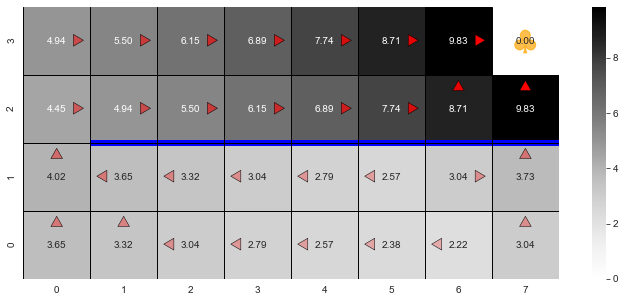

In [59]:
fig = plt.figure(figsize=(12, 5))
ax  = plt.subplot(111)
plot_maze_values(Q_MB, ax, hwall=[2, 1, 8], vwall=None)
# plt.savefig(os.path.join(os.getcwd(), 'belief_vi_h%u_values.png'%horizon))

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax  = plt.subplot(111)
plot_maze_values(IG, ax, hwall=[2, 1, 8], vwall=None)
# plt.savefig(os.path.join(os.getcwd(), 'belief_vi_h%u_ig.png'%horizon))

In [ ]:
Gain = np.zeros((num_states, num_actions))
for s in np.delete(range(num_states), r_state):
# for s in states:
    for a in range(num_actions):
        Gain[s, a] = gain(Q_MF[s, :], Q_MB[s, :], a, 0.5, 1.5)

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax  = plt.subplot(111)
plot_maze_values(Gain, ax, hwall=[2, 1, 8], vwall=None)
plt.savefig(os.path.join(os.getcwd(), 'belief_vi_h%u_gain.png'%horizon))

In [ ]:
def marginalise(T, Q):
    
    t      = np.zeros((num_states, num_states))
    for s in range(num_states):
        ps            = T[s*num_actions:s*num_actions+num_actions, :]
        action_probas = policy(Q[s, :], 1.5)
        for a in range(num_actions):
            if ~np.isnan(action_probas[a]):
                t[s, :] += action_probas[a]*ps[a, :]
                
    return t

In [ ]:
data3 = np.load('horizon3.npz')
Q_MB  = data3['Q_MB']

In [ ]:
T = M/np.sum(M, axis=1)[:, None]
t1  = marginalise(T, Q_MB)

In [ ]:
t2 = np.zeros((num_states, num_states))
for s in range(num_states):
    probs = policy(Q_MB[s, :], 1.5)
    for a in range(num_actions):
        if ~np.isnan(Q_MB[s, a]):
            for s1 in range(num_states):
                
                b   = M.copy()
                b   = b/np.sum(b, axis=1)[:, None]
                
                b1  = M.copy()
                b1[s*num_actions + a, s1] += 1
                b1  = b1/np.sum(b1, axis=1)[:, None]
                
                t2[s, :] += probs[a] * b[s*num_actions+a, s1] * b1[s*num_actions+a, :]

t3 = np.zeros((num_states, num_states))
for s in range(num_states):
    probs = policy(Q_MB[s, :], 1.5)
    for a in range(num_actions):
        if ~np.isnan(Q_MB[s, a]):
            for s1 in range(num_states):
                
                b   = M.copy()
                b   = b/np.sum(b, axis=1)[:, None]
                
                b1  = M.copy()
                b1[s*num_actions + a, s1] += 1
                
                probs1 = policy(Q_MB[s1, :], 1.5)
                for a1 in range(num_actions):
                    if ~np.isnan(Q_MB[s1, a1]):
                        for s2 in range(num_states):
                            
                            b2 = b1.copy()
                            b2[s1*num_actions + a1, s2] += 1
                            b2  = b2/np.sum(b2, axis=1)[:, None]
                            
                            b1  = b1/np.sum(b1, axis=1)[:, None]
                            
                            t3[s, :] += probs[a] * b[s*num_actions+a, s1] * probs1[a1] * b1[s1*num_actions+a1, s2] * b2[s1*num_actions+a1, :]

In [ ]:
SR = t1 + gamma*t2 + (np.linalg.inv(np.eye(num_states) - gamma*t3) - gamma*t3 - t3)
# SR = np.linalg.inv(np.eye(num_states) - gamma*t3)
# SR = np.linalg.inv(np.eye(num_states) - gamma*t2)
# SR = np.linalg.inv(np.eye(num_states) - gamma*t1)

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax  = plt.subplot(111)
plot_sr(SR, 27, ax, hwall=[2, 1, 8], vwall=None)